# Validate `alfresco_relative_flammability.py`

This notebook is for validating results from the `alfresco_relative_flammability.py` script. This script is intended to produce relative flammability estimates from ALFRESCO outputs. 

The approach taken is to 

1. manually compute relative flammability here
2. use the script on the same outputs
3. verify that the results from each are the same

## Testing set

The data used to test this are currently in `/atlas_scratch/apbennett/Calibration/HighCalib/FMO_Calibrated/`. These data are also available in `ls /workspace/Shared/Tech_Projects/SERDP_Fish_Fire/project_files/Calibration/HighCalib/FMO_Calibrated`

## Compute relative flammability

According to the [SNAP CKAN description](http://ckan.snap.uaf.edu/dataset/alfresco-model-outputs-relative-flammability), relative flammability "Counts the number of times a pixel burned through all replicates and time and divides that value by the total number of layers (replicates * years)"

So to implement this for a single century (100 years) for all replicates (200), relative flammability for a single pixel is computed as:

$$n / 100 * 200$$

Where $n$ is the total number of times a pixel burned across all replicates and time.

#### Input data: fire scar

It looks like number of fires for a pixel can be derived from fire scar files. According to this [JFSP report](https://drive.google.com/file/d/17bLAPkfq5i8dlrrBXmQNHvgoGspM3jRS/view?usp=sharing), band 3 is a boolean for ignition. Verify this with a sample file, rep 1 of year 2005:

In [1]:
import os
import time
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import tqdm
from multiprocessing import Pool
from rasterio.plot import show


# setup paths
base_dir = Path("/atlas_scratch/apbennett/Calibration/HighCalib/FMO_Calibrated/")
scratch_dir = Path("/atlas_scratch/kmredilla/aalfresco")

# model / scenario for testing
model = "CCSM4"
scenario = "rcp45"

In [2]:
temp_scar_fn = f"{model}_{scenario}_NoFMO/Maps/{{}}/FireScar_{{}}_{{}}.tif"
year = "2005"
rep = "1"
fp = base_dir.joinpath(temp_scar_fn.format(year, rep, year))

Band 1 should be only the year of burning. Unique values: 

In [10]:
with rio.open(fp) as src:
    print(np.unique(src.read(1)))

[-2147483647        2005]


Band 2 should be burn ID. Unique values:

In [11]:
with rio.open(fp) as src:
    print(np.unique(src.read(2)))

[-2147483647           1           2           3           4           5
           6           7           8           9          10          11
          12          13          14          15          16          17
          18          19          20          21          22          23
          24          25          26          27          28          29
          30          31          32          33          34          35
          36          37          38          39          40          41
          42          43          44          45          46          47
          48          49          50          51          52          53
          54          55          56          57          58          59
          60          61          62          63          64          65
          66          67          68          69          70          71
          72          73          74          75          76          77
          78          79          80          81   

Band 3 should be boolean for burn/no burn. Unique values:

[ 0.  1. nan]
Plot:


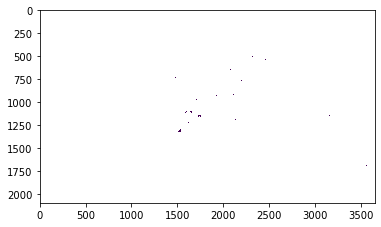

In [12]:
with rio.open(fp) as src:
    temp_arr = src.read(3).astype(float)
    temp_arr[temp_arr == src.meta["nodata"]] = np.nan
    print(np.unique(temp_arr))
    print("Plot:")
    plt.imshow(temp_arr, interpolation="none")

Zoom in on an area:

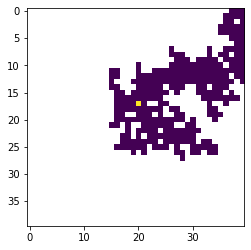

In [13]:
plt.imshow(temp_arr[1100:1140, 1560:1600], interpolation="none")

You can see this fire started with the yellow pixel and burned over all of the blue pixels. This confirms burn number can be derived from fire scar outputs - any pixel with data burned in that particular rep/year.

#### Compute relative flammability

Using these data, compute that relative flammability data. 

In [14]:
periods = {
    "1900-1999": np.arange(1901, 2000),
    "2000-2099": np.arange(2000, 2101),
}

In [15]:
model = "CCSM4"
scenario = "rcp45"

In [16]:
def read_burn(fp):
    with rio.open(fp) as src:
        temp_arr = src.read(3, masked=True)
        return (~temp_arr.mask)

    
# extract the data in prallel
# init empty counting array
total_arr = np.zeros((2100, 3650)).astype(int)

tic = time.perf_counter()

for year in periods["1900-1999"]:
    fps = list(base_dir.joinpath(f"{model}_{scenario}_NoFMO/Maps/").glob(f"{year}/FireScar*.tif"))

    with Pool(30) as pool:
        # chunk up printing a little bit
        if (year % 10 == 0) or (year == 1901):
            print(f"working on {year}'s")
            burn_arrs = [arr for arr in tqdm.tqdm(pool.imap_unordered(read_burn, fps), total=len(fps))]
        else:
            burn_arrs = pool.map(read_burn, fps)

    total_arr += np.sum(burn_arrs, axis=0)

et = round(time.perf_counter() - tic)
print(f"Elapsed time to count all burns: {et}s")

working on 1901's


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 62.25it/s]


working on 1910's


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 57.66it/s]


working on 1920's


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 60.82it/s]


working on 1930's


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 61.43it/s]


working on 1940's


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 52.93it/s]


working on 1950's


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 54.38it/s]


working on 1960's


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 57.80it/s]


working on 1970's


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 56.87it/s]


working on 1980's


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 59.89it/s]


working on 1990's


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 56.38it/s]


Elapsed time to count all burns: 809s


In [17]:
# compute relative flammability
relflam_arr = total_arr.astype(np.float32) / (len(fps) * len(periods["1900-1999"]))

Relative flammability of domain:

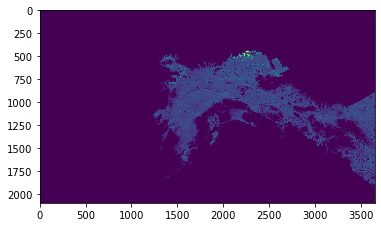

In [18]:
plt.imshow(relflam_arr, interpolation="none")

Looks reasonable. Counts of burns:

(array([6.551746e+06, 5.436220e+05, 5.428540e+05, 1.884100e+04,
        3.607000e+03, 1.895000e+03, 9.680000e+02, 6.660000e+02,
        5.360000e+02, 2.650000e+02]),
 array([  0. ,  59.6, 119.2, 178.8, 238.4, 298. , 357.6, 417.2, 476.8,
        536.4, 596. ]),
 <BarContainer object of 10 artists>)

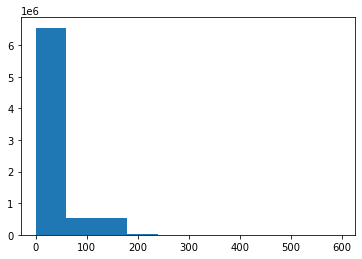

In [19]:
plt.hist(total_arr.flatten())

So max is somewhere around 600, which makes sense with the max possible being $100 x 200 = 2000$. Write the results:

In [13]:
out_fp = scratch_dir.joinpath(f"alf_relflam_manual_{model}_{scenario}_1900_1999.tif")

In [22]:
# to match the script, need to read in mask from veg file and apply it
mask = rio.open(str(fps[0]).replace("FireScar_", "Veg_")).read_masks(1)
mask = (mask == 255).astype(int)
mask_value = -9999.0
relflam_arr[mask == 0] = mask_value

In [23]:
# get metadata from an input fp
with rio.open(fp) as src:
    meta = src.meta.copy()

meta.update({"dtype": "float32", "nodata": mask_value})

# rounded to 4 decimal places in script
with rio.open(out_fp, "w", **meta) as dst:
    dst.write(np.around(relflam_arr, 4), 1)

## Compute using `alfresco_relative_flammability.py` script

Now apply the `alfresco_relative_flammability.py` to the same model / scenario and years.

In [11]:
maps_path = base_dir.joinpath(f"{model}_{scenario}_NoFMO/Maps/")
ncores = "30"
begin_year = "1900"
end_year = "1999"
output_filename = scratch_dir.joinpath(f"alf_relflam_test_{model}_{scenario}_{begin_year}_{end_year}.tif")

In [12]:
# 
script_run = os.system((
    "cd "
    "../bin/ "
    "&& "
    "python " 
    "alfresco_relative_flammability.py "
    "-p "
    f"{maps_path} "
    "-o "
    f"{output_filename} "
    "-nc "
    f"{ncores} "
    "-by "
    f"{begin_year} "
    "-ey "
    f"{end_year}"
))

running firescar groups summation
firescar groups summation done. summing all groups
firescar summation done
Relative flammability computed, results written to /atlas_scratch/kmredilla/aalfresco/alf_relflam_test_CCSM4_rcp45_1900_1999.tif
Elapsed time: 6.2m


## Compare the results

Compare the results from both approaches:

In [14]:
with rio.open(out_fp) as src1:
    with rio.open(output_filename) as src2:
        print("Relative flammability arrays match: ", np.all(src1.read(1) == src2.read(1)))

Relative flammability arrays match:  True


The script appears to work as expected!

## Compare with existing relative flammability rasters

There are some existing relative flammability files in `/workspace/Shared/Tech_Projects/SERDP_Fish_Fire/project_files/Calibration/HighCalib/FMO_Calibrated/RelativeFlammability/`. These are of interest because they could possibly be used, if we knew what the time periods were and if they were produced with the validated script. But they don't have time-ranges in the filenames:

In [127]:
ls /workspace/Shared/Tech_Projects/SERDP_Fish_Fire/project_files/Calibration/HighCalib/FMO_Calibrated/RelativeFlammability/

alfresco_relative_flammability_CCSM4_rcp45_NoFMO.tif
alfresco_relative_flammability_CCSM4_rcp45.tif
alfresco_relative_flammability_CCSM4_rcp85_NoFMO.tif
alfresco_relative_flammability_CCSM4_rcp85.tif
alfresco_relative_flammability_GFDL-CM3_rcp45_NoFMO.tif
alfresco_relative_flammability_GFDL-CM3_rcp45.tif
alfresco_relative_flammability_GFDL-CM3_rcp85_NoFMO.tif
alfresco_relative_flammability_GFDL-CM3_rcp85.tif
alfresco_relative_flammability_GISS-E2-R_rcp45_NoFMO.tif
alfresco_relative_flammability_GISS-E2-R_rcp45.tif
alfresco_relative_flammability_GISS-E2-R_rcp85_NoFMO.tif
alfresco_relative_flammability_GISS-E2-R_rcp85.tif
alfresco_relative_flammability_IPSL-CM5A-LR_rcp45_NoFMO.tif
alfresco_relative_flammability_IPSL-CM5A-LR_rcp45.tif
alfresco_relative_flammability_IPSL-CM5A-LR_rcp85_NoFMO.tif
alfresco_relative_flammability_IPSL-CM5A-LR_rcp85.tif
alfresco_relative_flammability_MRI-CGCM3_rcp45_NoFMO.tif
alfresco_relative_flammability_MRI-CGCM3_rcp45.tif
alfresco_relative_flammability_MRI-C

So here is a test to see if they match the 1900-1999 file:

In [128]:
fp = (
    "/workspace/Shared/Tech_Projects/SERDP_Fish_Fire/project_files/Calibration/HighCalib/FMO_Calibrated/"
    "RelativeFlammability/alfresco_relative_flammability_CCSM4_rcp45_NoFMO.tif"
)
with rio.open(fp) as src1:
    with rio.open(output_filename) as src2:
        print("Relative flammability arrays match: ", np.all(src1.read(1) == src2.read(1)))

Relative flammability arrays match:  False


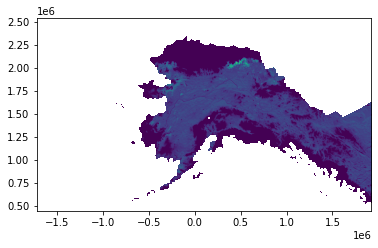

In [136]:
with rio.open(fp) as src1:
    show(src1)

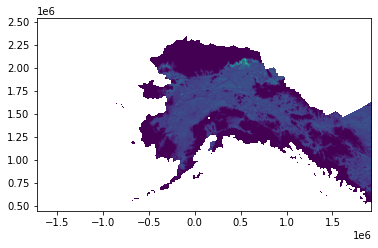

In [139]:
with rio.open(output_filename) as src2:
    show(src2)

So instead of more guessing, we will just recompute for the desired years / models elsewhere. 